# Thermal stability of hundreds of point mutants of a family 1 glycoside hydrolase 

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas
from scipy.optimize import curve_fit 
from numpy import log, exp, linspace, sqrt, diag
from sklearn.linear_model import LinearRegression
import os
import re 

df = pandas.read_csv( 'data/Bagel Thermostability - cleaned_data.csv' )
raw = len( df )
df.index = df.mutant
df.drop( 'mutant', inplace=True )
df.drop( ['WT', 'WT1'], inplace=True )
df.dropna( inplace=True ) 

with open( 'data/allowed_mutants.txt' ) as fn:
    mutants = [ i.split('.')[0].upper() for i in fn.readlines() if len( i ) > 1 ]
    
def is_good( name ):
    return name in mutants 

# this is a sanity-checking routine for "off-by-threes" 
l = []
for name in df.index:
    #print name
    if is_good( name ):
        l.append( name )
    else:
        new = name[0] + str( int( re.findall( r'\d+', name )[0] ) - 3 ) + name[-1]
        if is_good( new ):
            l.append( new )
        else:
            l.append( 'drop_me' )
            
df.index = l
df.drop( ['drop_me'], inplace=True )

# temperature keys as CSV files in data/
temp_key = pandas.read_csv( 'data/temp_key.csv' )
temp_key.index = temp_key.Well
df['temp'] = df.well.str[0].map( temp_key.Celsius.to_dict() ) 
df.dropna( inplace=True )
df.sample( 10 )
print '{} individual rates will be used (dropped {})'.format( len( df ), raw - len( df ) )

3145 individual rates will be used (dropped 168)


# Curve fit to logistic equation

In [11]:
# logistic equation 
def f(x, x0, k): 
    return 1/(1+exp(-k*(x-x0)))

# util function to fit a mutant 
def fit( df ):
    name = df.mutant.unique()[0]
    df.rate = df.rate / df.rate.max()
    
    # linear fit 
    reg = LinearRegression()
    reg.fit( df.temp.reshape(-1, 1), df.rate )
    slope = reg.coef_[0]
    
    # try fitting to logistic eqn 
    try:
        p0 = ( df.temp.mean(), slope )
        popt, pcov = curve_fit( f, df.temp, df.rate, p0=p0 )
        perr = sqrt( diag( pcov ) ) 
        if 30 < popt[0] < 50: # biological assay limits 
            return pandas.Series( popt, index=['tm', 'k'] )
        else:
            #iffy += [ name ]
            raise Exception( 'Warning: dropping fit for {0} because Tm of {1:2.2f} is outside range 30-50 C'.format( name, popt[0] ) )
    except Exception as e:
        print e
    
grouped = df.groupby( by='mutant' )
fits = grouped.apply( fit )
print ''
print 'Successfully fit {} of {} samples to the logistic equation'.format( len( fits ), len( grouped ) )


Successfully fit 119 of 119 samples to the logistic equation


/home/carlin/bin/anaconda/lib/python2.7/site-packages/scipy/optimize/minpack.py:604: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [12]:
fits

,tm,k
mutant,,
A195S,39.100764,-0.931507
A356A,39.886138,-1.122859
A357A,39.113754,-0.326374
A408A,39.958372,-1.263093
C167A,39.736959,-1.389863
C167Q,38.474155,-0.533021
D403A,NaN,NaN
E154D,38.685433,-0.694348
E164A,NaN,NaN


## Diagnostic plots to help determine goodness of fits

In [14]:
!mkdir plots 
for index, df in grouped:
    name = df.mutant.unique()[0]
    rate = df.rate / df.rate.max() # have to do this again
    plt.figure( figsize=(2,2) )
    plt.scatter( df.temp, rate, alpha=0.7, color='black', marker='.' )
    popt = fits.loc[ name ]
    if popt is not None:
        x_space = linspace( df.temp.min(), df.temp.max(), 100 )
        plt.plot( x_space, f( x_space, *popt ), alpha=0.5, color='purple' )
    plt.xlabel( 'T (C)' )
    plt.ylabel( 'Normalized rate')
    plt.xticks( [ 30, 40, 50 ] )
    plt.yticks( [ 0, 0.5, 1 ] )
    plt.title( name )
    plt.tight_layout()
    plt.savefig( 'plots/%s.pdf' % name, format='pdf' )
    #plt.show()
    plt.close()

## Clean up and apply what we learned from the plots to the data set 

In [15]:
# nothing here, yet! 

In [16]:
# add metadata
fits['native'] = fits.index.str[0]
fits['designed'] = fits.index.str[-1]
fits['position'] = fits.index.str[1:-1].astype( int )
fits.sample( 10 )

,tm,k,native,designed,position
mutant,,,,,
W399C,NaN,NaN,W,C,399
W399R,NaN,NaN,W,R,399
R240A,38.312285,-0.595932,R,A,240
W407A,NaN,NaN,W,A,407
M323K,38.608623,-1.066339,M,K,323
E154D,38.685433,-0.694348,E,D,154
E222Q,39.421907,-0.815076,E,Q,222
W399S,NaN,NaN,W,S,399
Q19C,34.309899,-0.041197,Q,C,19


In [25]:
# makes resfiles for DDG Rosetta app 
!mkdir ddg/resfiles 

for ( index, series ) in fits.iterrows():
    with open( 'ddg/resfiles/{}'.format( index ), 'w' ) as fn:
        fn.write( 'NATRO\nSTART\n{} A PIKAA {}'.format( series.position, series.designed ) )

mkdir: cannot create directory ‘ddg/resfiles’: File exists


In [39]:
%%bash 

ls ddg/resfiles > ddg/list
NUM=$( wc -l ddg/list | cut -d' ' -f1 )
cd ddg && sbatch --array=1-${NUM} sub.sh 

Submitted batch job 146644


## Comparison between Rosetta `ddg_monomer` app and experimental results

In [19]:
! ( head -1 ddg/ddg_predictions.out && grep -v desc ddg/ddg_predictions.out ) > ddg/readable_output

In [21]:
!ls ddg

bglb.pdb	     ddg_preds.csv  pNPG.enzdes.cst  readable_output  sub.sh
ddg_predictions.out  flags	    pNPG.params      resfiles


In [22]:
preds = pandas.read_csv( 'ddg/readable_output', sep='\s+' )
preds.index = preds.description.values
joined = preds.join( fits )
joined.sample( 10 )

,ddG:,description,total,fa_atr,fa_rep,fa_sol,fa_intra_rep,fa_elec,pro_close,hbond_sr_bb,...,fa_dun,p_aa_pp,ref,chainbreak,res_type_constraint,tm,k,native,designed,position
S169P,ddG:,S169P,11.215,1.138,8.279,-5.726,0.014,-0.650,1.291,1.340,...,2.650,0.995,-0.396,0,0,NaN,NaN,NaN,NaN,NaN
H101R,ddG:,H101R,3.084,3.550,-0.581,-4.436,-0.003,4.233,-0.054,-0.086,...,-0.144,0.005,-0.507,0,0,40.023845,-0.912275,H,R,101
Y75H,ddG:,Y75H,3.305,1.674,-2.389,1.336,-0.023,0.777,-0.018,-0.230,...,-0.301,-0.211,0.226,0,0,NaN,NaN,NaN,NaN,NaN
E406D,ddG:,E406D,10.201,-0.375,-0.568,0.573,0.011,4.873,0.405,0.217,...,-1.531,-0.245,0.267,0,0,40.546530,-1.017074,E,D,406
W407R,ddG:,W407R,12.019,5.413,-0.969,5.741,-0.028,1.746,0.018,-0.077,...,-1.148,-1.007,-1.078,0,0,NaN,NaN,W,R,407
Q313R,ddG:,Q313R,-2.293,-8.086,0.624,10.938,0.000,-5.328,0.277,0.620,...,1.263,0.160,1.029,0,0,42.111481,-1.205015,Q,R,313
Q19A,ddG:,Q19A,2.246,7.313,-0.032,-7.922,-0.002,0.611,0.293,0.448,...,-2.187,0.023,1.771,0,0,NaN,NaN,Q,A,19
W34A,ddG:,W34A,8.512,21.478,-3.590,-6.014,-0.017,0.261,-0.327,-0.041,...,-2.405,-0.293,-0.336,0,0,NaN,NaN,W,A,34
W407R,ddG:,W407R,7.325,10.600,-2.459,0.372,-0.031,0.944,-0.001,-0.085,...,-0.763,-1.078,-1.078,0,0,NaN,NaN,W,R,407
E177A,ddG:,E177A,-0.361,7.804,-1.012,-10.885,0.003,3.759,-0.049,-0.583,...,-6.020,-0.379,2.147,0,0,37.311680,-0.488365,E,A,177


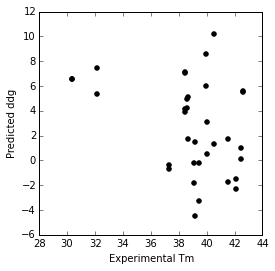

In [23]:
plt.figure( figsize=( 4, 4 ) )
plt.scatter( joined.tm, joined.total, color='k' )
plt.xlabel( 'Experimental Tm' )
plt.ylabel( 'Predicted ddg' )